In [8]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

import os

import pandas as pd  # Used for dealing with the CSV files; has a richer interface than the csv module
import pathlib
import pyproj  # For converting between lon/lat and PS71 + along-track ellipsoidal distance calcuations

import requests  # For downloading index page
import shapefile as shp  # Requires the pyshp package; I ran `pip install pyshp`

from bs4 import BeautifulSoup   # For parsing html and extracting the links


#### I want a simple basemap for context....

So grab the ASAID grounding line from Quantarctica3

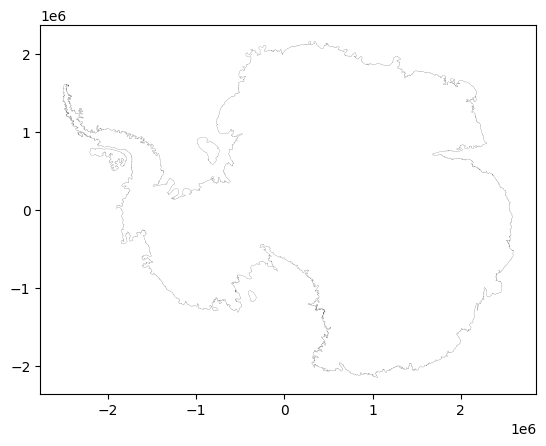

In [9]:
# I want to show individual surveys on an Antarctic basemap for context
# I have the simplified grounding file as part of Quantarctica 
# TODO: This dependency is ugly, and won't work on other computers. Download it separately?
gl_filepath = "/Users/lindzey/ADATA/Quantarctica/Quantarctica3/Glaciology/ASAID/ASAID_GroundingLine_Simplified.shp"

# Example code from https://gis.stackexchange.com/questions/131716/plot-shapefile-with-matplotlib

sf = shp.Reader(gl_filepath)

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]    
    plt.plot(x, y, 'k', linewidth=0.1)
plt.show()


In [10]:
# If I do it this way, I can plot as points (but not lines!). This is easier than having to iterate through each segment.
sf = shp.Reader(gl_filepath)
gl_xx = []
gl_yy = []
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    gl_xx.extend(x)
    gl_yy.extend(y)

### Calculating along-track distance
* Calculate along-track ellipsoidal distances
* Given along-track distance, drop most of the points

In [11]:
# Let's try plotting a UTIG season
in_path = "/Volumes/RadarData/BEDMAP/BEDMAP2/UTIG_2008_ICECAP_AIR_BM2.csv"
data = pd.read_csv(in_path, skiprows=18)

lon_index = [col for col in data.columns if 'longitude' in col][0]
lat_index = [col for col in data.columns if 'latitude' in col][0]
lon = data[lon_index]
lat = data[lat_index]

ps71=pyproj.Proj('epsg:3031')
xx, yy = ps71.transform(lon, lat)


In [12]:
geod = pyproj.Geod(ellps="WGS84")
lengths = geod.line_lengths(lon, lat)

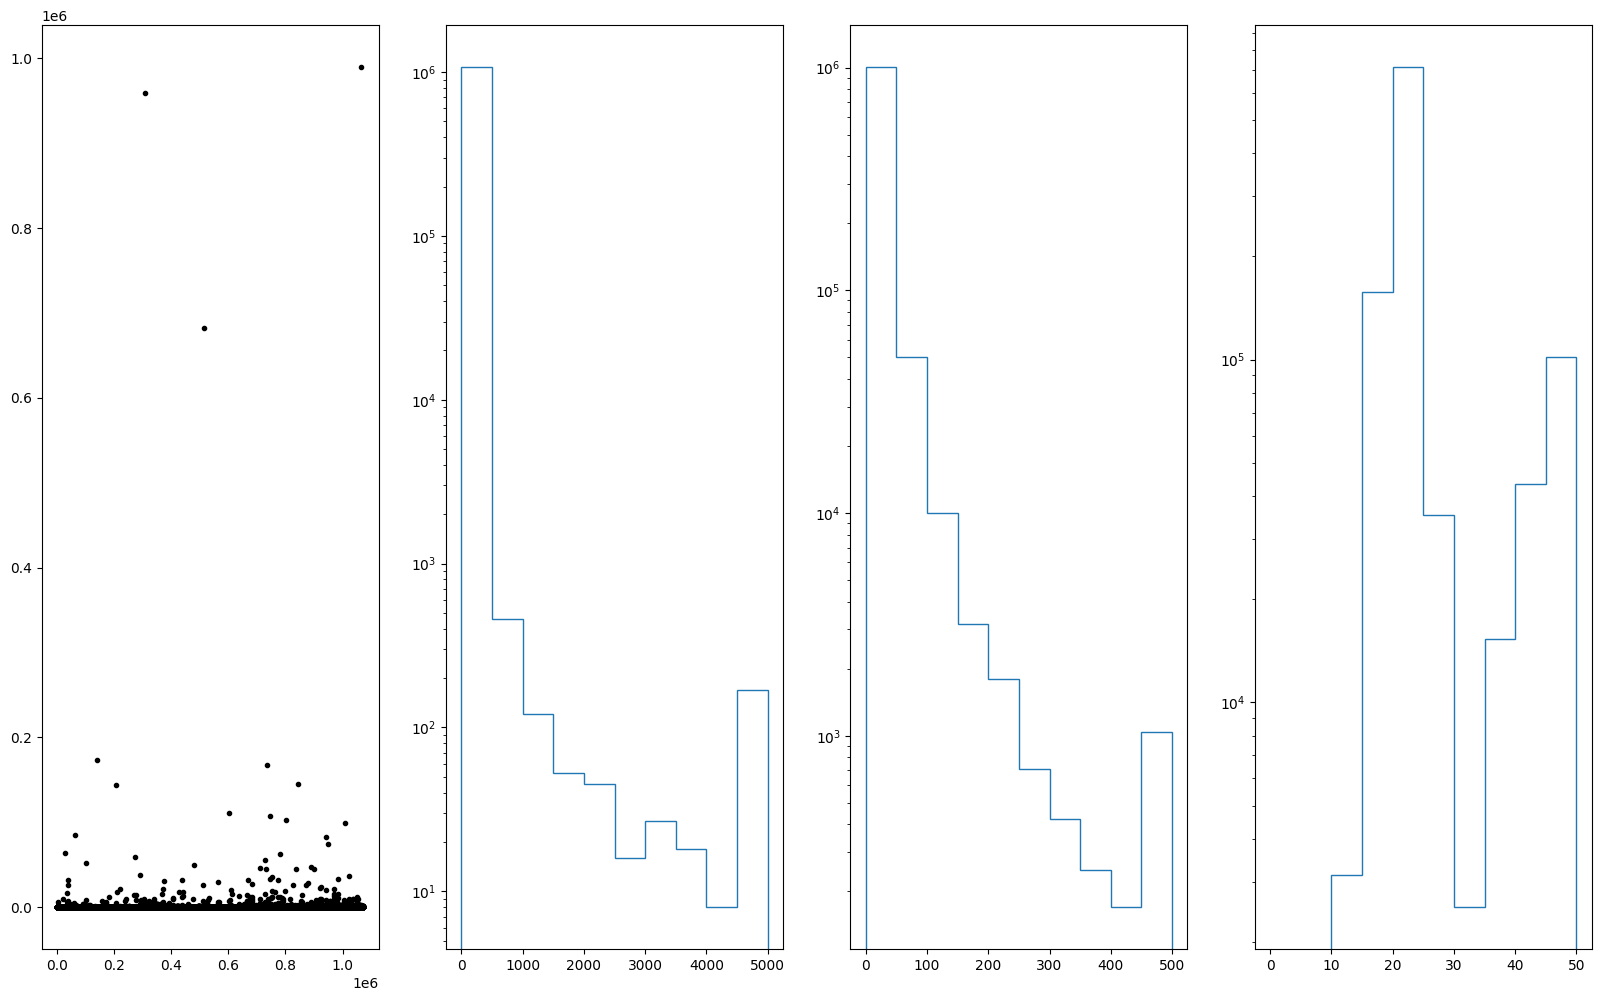

In [13]:
# Plot total distance and incremental step
import numpy as np
fig = plt.figure(figsize=(20, 12))
ax1, ax2, ax3, ax4 = fig.subplots(1, 4)
ax1.plot(lengths, 'k.')

max_dist = 5000
clipped_lengths = np.clip(lengths, 0, max_dist)  # We want outliers in last bin
counts, bins = np.histogram(clipped_lengths, range=[0, max_dist])
ax2.stairs(counts, bins)
ax2.set_yscale('log')

max_dist = 500
clipped_lengths = np.clip(lengths, 0, max_dist)
counts, bins = np.histogram(clipped_lengths, range=[0, max_dist])
ax3.stairs(counts, bins)
ax3.set_yscale('log')

max_dist = 50
clipped_lengths = np.clip(lengths, 0, max_dist)
counts, bins = np.histogram(clipped_lengths, range=[0, max_dist])
ax4.stairs(counts, bins)
ax4.set_yscale('log')

Cool! Based on these plots, 100m along-track spacing would probably decrease data size by a factor of ~4. 
This is in addition to only maintaining two of the fields, for a potential 6x improvement.
I'm arbitrarily going to try 200m sampling for ~8x (48x?) space improvement. 

Q: I wonder if it's possible to have the layer connect points by a line if they are sequential AND separated by less than some spacing. That might look better than keeping everything as points. 

### Subsample the data

In [14]:
lon = data[lon_index]
lat = data[lat_index]
xx, yy = ps71.transform(lon, lat)

min_spacing = 200  # meters
keep_idxs = [0]

cumulative_dist = 0
for idx, segment_dist in enumerate(lengths):
    cumulative_dist += segment_dist
    if cumulative_dist >= min_spacing:
        keep_idxs.append(idx+1)  # Segment index idx is between point[idx] and point[idx+1]
        cumulative_dist = 0
        
print("Original dataset has {} points; subsampled has {} ({:0.1f} %)".format(len(lon), len(keep_idxs), 100*len(keep_idxs)/len(lon)))


Original dataset has 1072811 points; subsampled has 136535 (12.7 %)


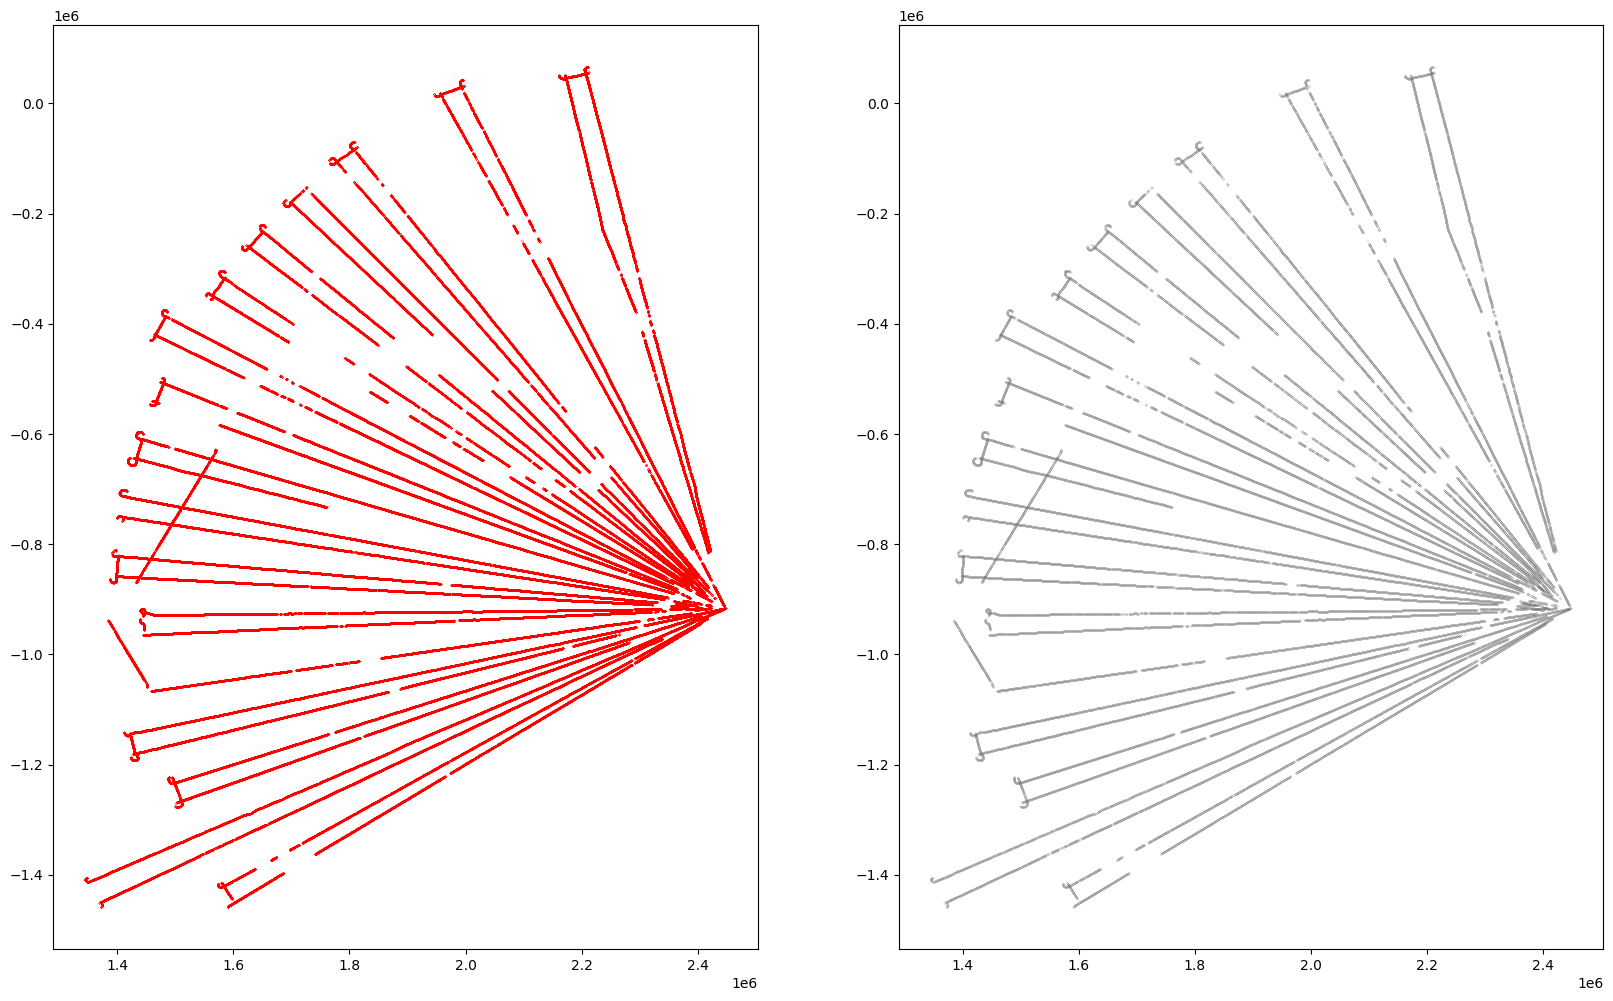

In [15]:
fig = plt.figure(figsize=(20, 12))
ax1, ax2 = fig.subplots(1, 2)
ax1.plot(xx, yy, 'r.', markersize=0.1)
ax2.plot(xx[keep_idxs], yy[keep_idxs], '.', color='grey', markersize=0.1)


OK, so for the ICECAP data, subsampling to 200m is definitely fine for the high-level overview.

### Create subsampled CSV files

This is probably just a stepping stone to a QGIS layer, but I'm not yet sure what the right way is to create the layer with nested groups

In [17]:
data_dir = "/Volumes/RadarData/BEDMAP"

institutions = {}

for compilation in os.listdir(data_dir):
    compilation_dir = os.path.join(data_dir, compilation)
    for filename in os.listdir(compilation_dir):
        if filename.startswith('.'):
            continue
        elif filename.startswith('BEDMAP1'):
            institution = "BEDMAP1"
            year = 1966
            air = True
            campaign = "BEDMAP1"
        else:
            ff = filename.strip('.csv')
            tokens = ff.split('_')
            institution = tokens[0]
            year = int(tokens[1])
            air = "AIR" == tokens[-2]
            campaign = "_".join(tokens[2:-2])
        if institution not in institutions:
            institutions[institution] = []
        filepath = os.path.join(compilation_dir, filename) # Cache this for later processing
        institutions[institution].append((year, campaign, air, filepath))


In [18]:
institutions.keys()

dict_keys(['UTIG', 'UCANTERBURY', 'STOLAF', 'RNRF', 'PRIC', 'NPI', 'NIPR', 'NASA', 'LDEO', 'INGV', 'BGR', 'BAS', 'AWI', 'UWASHINGTON', 'ULB', 'STANFORD', 'KOPRI', 'CRESIS', 'CECS', 'BEDMAP1'])

In [19]:
institutions['LDEO']

[(2007,
  'Recovery-Lakes',
  True,
  '/Volumes/RadarData/BEDMAP/BEDMAP2/LDEO_2007_Recovery-Lakes_AIR_BM2.csv'),
 (2007,
  'AGAP-GAMBIT',
  True,
  '/Volumes/RadarData/BEDMAP/BEDMAP2/LDEO_2007_AGAP-GAMBIT_AIR_BM2.csv'),
 (2015,
  'ROSETTA',
  True,
  '/Volumes/RadarData/BEDMAP/BEDMAP3/LDEO_2015_ROSETTA_AIR_BM3.csv')]

In [20]:
len(institutions)

20

In [21]:
# Rather than sorting primarily by which version of bedmap they were in, I want to sort primarily by institution, then by campaign
# So my subsampled output files will be targ/BEDMAP/[institution]/year_campaign.csv 

In [22]:
def load_lat_lon(filepath):
    '''Open file in the BEDMAP CVS format and extract just lat long from it'''
    data = pd.read_csv(filepath, skiprows=18)

    lon_index = [col for col in data.columns if 'longitude' in col][0]
    lat_index = [col for col in data.columns if 'latitude' in col][0]
    lon = data[lon_index]
    lat = data[lat_index]
    return lat, lon

In [23]:
def subsample_tracks(lat, lon, min_spacing):
    '''
    Subsample the input coordinates so sequential points are separated by at least min_spacing.
    This assumes that the BEDMAP CSVs provide coordinate in sequential order w/r/t data collection
    '''
    geod = Geod(ellps="WGS84")
    lengths = geod.line_lengths(lon, lat)
    keep_idxs = [0]

    cumulative_dist = 0
    for idx, segment_dist in enumerate(lengths):
        cumulative_dist += segment_dist
        if cumulative_dist >= min_spacing:
            keep_idxs.append(idx+1)  # Segment index idx is between point[idx] and point[idx+1]
            cumulative_dist = 0
    return lat[keep_idxs], lon[keep_idxs]


In [24]:
print(filepath)

/Volumes/RadarData/BEDMAP/BEDMAP1/BEDMAP1_1966-2000_AIR_BM1.csv


In [26]:
output_dir = "/Users/lindzey/Documents/QIceRadar/data_index/subsampled_bedmap"

In [46]:
min_spacing = 200  # meters between successive points
ps71=pyproj.Proj('epsg:3031')

for institution, campaigns in institutions.items():
    print("Subsampling {}".format(institution))
    for campaign in campaigns:
        year, campaign_name, air, datafilepath = campaign
        institution_dir = os.path.join(output_dir, institution)
        try:
            pp = pathlib.Path(institution_dir)
            pp.mkdir(parents=True, exist_ok=True)
        except FileExistsError as ex:
            raise Exception("Could not create {}: {}.".format(institution_dir, ex))
        outfilename = datafilepath.split("/")[-1]
        outfilepath = os.path.join(institution_dir, outfilename)
        lat, lon = load_lat_lon(datafilepath)
        lat, lon = subsample_tracks(lat, lon, min_spacing)
        xx, yy = ps71.transform(lon, lat)
        with open(datafilepath, 'r') as in_fp, open(outfilepath, 'w') as out_fp:
            for _ in range(18):
                line = in_fp.readline()
                out_fp.write(line)
            out_fp.write("ps71_easting, ps71_northing\n")
            out_fp.writelines(["{},{}\n".format(pt[0], pt[1]) for pt in zip(xx, yy)])


Subsampling UTIG
Subsampling UCANTERBURY
Subsampling STOLAF
Subsampling RNRF


/var/folders/rn/_v8bq9w166j6zdpz3s7f67c40000gn/T/ipykernel_8300/3460480193.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath, skiprows=18)
/var/folders/rn/_v8bq9w166j6zdpz3s7f67c40000gn/T/ipykernel_8300/3460480193.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath, skiprows=18)
/var/folders/rn/_v8bq9w166j6zdpz3s7f67c40000gn/T/ipykernel_8300/3460480193.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath, skiprows=18)
/var/folders/rn/_v8bq9w166j6zdpz3s7f67c40000gn/T/ipykernel_8300/3460480193.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath, skiprows=18)
/var/folders/rn/_v8bq9w166j6zdpz3s7f67c40000gn/T/ipykernel_8300/3460480193.py:3: DtypeWarning: Colum

Subsampling PRIC
Subsampling NPI
Subsampling NIPR
Subsampling NASA
Subsampling LDEO
Subsampling INGV
Subsampling BGR
Subsampling BAS
Subsampling AWI
Subsampling UWASHINGTON
Subsampling ULB
Subsampling STANFORD
Subsampling KOPRI
Subsampling CRESIS
Subsampling CECS
Subsampling BEDMAP1


## Associating with existing lines

Ideally, I'd be able to determine whether QIceRadar already supports all data from a given CSV file, but I suspect that will be a bit of a lost cause.

The metadata fields include Institution, Source (DOI for data), Reference (DOI for paper citation).

This will help me *find* missing data, but I'll be somewhat surprised if the source DOIs match up with my metadata for the extracted points. OOOOH. date/time/lat/lon will be pretty darn unique. Computationally intensive (unless I can filter by institution and/or use some of QGIS's built-in processing functions), but it *should* be possible to remove points from the bedmap dataset if they appear in my subsampled one. However, UTIG doesn't include timestamps on all of their data. 